<a href="https://colab.research.google.com/github/etemadism/Courses/blob/main/GROMACS_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **GROMACS MD**


### Installation on Google Colab

The following code cells will install all required packages, if you are working on [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb). Installing the [condacolab](https://github.com/jaimergp/condacolab) package will restart the kernel, which is intended. This notebook can also be used on a local computer but requires considerable computing power.

In [ ]:
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


##Conda

In [ ]:
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj openmm openmmforcefields pdbfixer pypdb rdkit
    on_colab = True
    clear_output()  # clear the excessive installation outputs
    print("Dependencies successfully installed!")
except ModuleNotFoundError:
    on_colab = False

Dependencies successfully installed!


In [ ]:
# imports
import sys
import copy
from pathlib import Path

from IPython.display import display
import numpy as np
#from rdkit import Chem
#from rdkit.Chem import Draw
#from rdkit.Chem import AllChem
#from pypdb import get_pdb_file
#import mdtraj as md
#import pdbfixer
#import simtk.openmm as mm
#import simtk.openmm.app as app
#from simtk.openmm import unit
#from openff.toolkit.topology import Molecule, Topology
#from openmmforcefields.generators import GAFFTemplateGenerator

## **Step 1:** Run on GPU (25min)

In [ ]:
# 1. Install dependencies
!apt-get update
!apt-get install -y build-essential cmake git libfftw3-dev libgsl-dev

# 2. Download GROMACS 2021.4
%cd /content
!rm -rf gromacs build
!git clone https://github.com/gromacs/gromacs.git
%cd gromacs
!git checkout v2021.4

# 3. Create build directory
!mkdir build
%cd build

# 4. Configure for Tesla T4 (SM 75)
!cmake ../ -DGMX_BUILD_OWN_FFTW=ON -DGMX_GPU=CUDA -DGMX_CUDA_TARGET_SM=75 -DCMAKE_INSTALL_PREFIX=/usr/local/gromacs

# 5. Compile (adjust -j for Colab vCPUs)
!make -j2
!make install

# 6. Source GROMACS and check
!bash -c "source /usr/local/gromacs/bin/GMXRC && gmx --version"


Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,196 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,842 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-bac

In [ ]:
%cd /content/

/content


In [ ]:
!wget https://mackerell.umaryland.edu/download.php?filename=CHARMM_ff_params_files/charmm36-jul2022.ff.tgz  -O charmm36-jul2022.ff.tgz

--2025-12-05 11:19:40--  https://mackerell.umaryland.edu/download.php?filename=CHARMM_ff_params_files/charmm36-jul2022.ff.tgz
Resolving mackerell.umaryland.edu (mackerell.umaryland.edu)... 134.192.35.52
Connecting to mackerell.umaryland.edu (mackerell.umaryland.edu)|134.192.35.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105332 (1.1M) [application/x-gzip]
Saving to: ‘charmm36-jul2022.ff.tgz’

charmm36-jul2022.ff 100%[===================>]   1.05M  1.41MB/s    in 0.7s    

2025-12-05 11:19:41 (1.41 MB/s) - ‘charmm36-jul2022.ff.tgz’ saved [1105332/1105332]



In [ ]:
!tar -xzf charmm36-jul2022.ff.tgz

## **Step 2:** pdb2gmx

In [ ]:
pdb_name = "1B9E"

print(f"Step 1: Downloading {pdb_name}.pdb...")
!wget -q https://files.rcsb.org/download/{pdb_name}.pdb -O {pdb_name}.pdb
print(f"Downloaded {pdb_name}.pdb")

print(f"\nStep 2: Cleaning the PDB (remove water HOH and HETATM)...")
!grep -v -E "HOH|HETATM" {pdb_name}.pdb > {pdb_name}_cleaned.pdb
print(f"Cleaned PDB saved as {pdb_name}_cleaned.pdb")

print(f"\nStep 3: Downloading renumber_pdb.py script...")
!wget -q https://raw.githubusercontent.com/rasbt/protein-science/master/scripts-and-tools/renumber_pdb/renumber_pdb.py -O renumber_pdb.py
print("Downloaded renumber_pdb.py")

print(f"\nStep 4: Renumbering residues starting from 1...")
!python3 renumber_pdb.py -i {pdb_name}_cleaned.pdb -s 1 -r > {pdb_name}_cleaned_renum.pdb
print(f"Renumbered PDB saved as {pdb_name}_cleaned_renum.pdb")

print(f"\nStep 5: Running pdb2gmx with cleaned and renumbered PDB (CHARMM36, TIP3P)...")
!/usr/local/gromacs/bin/gmx pdb2gmx -f {pdb_name}_cleaned_renum.pdb -o {pdb_name}_processed.gro -water tip3p -ff charmm36-jul2022 -ignh 2>&1 | tee pdb2gmx.log
print(f"pdb2gmx completed. Output: {pdb_name}_processed.gro")


Step 1: Downloading 1B9E.pdb...
Downloaded 1B9E.pdb

Step 2: Cleaning the PDB (remove water HOH and HETATM)...
Cleaned PDB saved as 1B9E_cleaned.pdb

Step 3: Downloading renumber_pdb.py script...
Downloaded renumber_pdb.py

Step 4: Renumbering residues starting from 1...
Renumbered PDB saved as 1B9E_cleaned_renum.pdb

Step 5: Running pdb2gmx with cleaned and renumbered PDB (CHARMM36, TIP3P)...
     :-) GROMACS - gmx pdb2gmx, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eri

## **Step 3:** Adding a box

In [ ]:
# gmx editconf: Define the simulation box
# -f protein.gro: input structure file
# -o boxed.gro: output structure file with box defined
# -c: center the protein in the box
# -d 1.0: distance from protein to box edge (1.0 nm)
# -bt cubic: box type (cubic)

!!/usr/local/gromacs/bin/gmx editconf -f protein_processed.gro -o protein_boxed.gro -bt dodecahedron -d 1.0 -c

['     :-) GROMACS - gmx editconf, 2021.4-dev-20211104-8a43d865d0-unknown (-:',
 '',
 '                            GROMACS is written by:',
 '     Andrey Alekseenko              Emile Apol              Rossen Apostolov     ',
 '         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       ',
 '       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        ',
 '     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      ',
 '    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      ',
 '       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      ',
 '      Aleksei Iupinov           Christoph Junghans             Joe Jordan        ',
 '    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        ',
 '      Carsten Kutzner              Per Larsson              Justin A. Lemkul     ',
 '       Viveca Lindahl            Magnus Lundborg             Erik Marklund       ',


add solvate

In [ ]:
# gmx solvate: Add solvent molecules to the box
# -cp boxed.gro: input protein in a box
# -cs spc2.gro: solvent molecule structure file (gmx solvate typically uses a default or infers from topology)
# -o solvated.gro: output solvated system structure file
# -p topol.top: topology file to update with solvent molecules
# Note: GROMACS will typically use the water model defined in the force field (TIP3P in our case) or
# look for a common solvent model like 'spc2.gro' or 'tip3p.gro' in the force field directory.
# We will use 'spc2.gro' as a common placeholder; GROMACS will either find a suitable water model
# or prompt if multiple are available. Given our selection of TIP3P earlier, it should be used.

!!/usr/local/gromacs/bin/gmx solvate -cp protein_boxed.gro -cs spc216.gro -o protein_solv.gro -p topol.top

['     :-) GROMACS - gmx solvate, 2021.4-dev-20211104-8a43d865d0-unknown (-:',
 '',
 '                            GROMACS is written by:',
 '     Andrey Alekseenko              Emile Apol              Rossen Apostolov     ',
 '         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       ',
 '       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        ',
 '     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      ',
 '    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      ',
 '       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      ',
 '      Aleksei Iupinov           Christoph Junghans             Joe Jordan        ',
 '    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        ',
 '      Carsten Kutzner              Per Larsson              Justin A. Lemkul     ',
 '       Viveca Lindahl            Magnus Lundborg             Erik Marklund       ',
 

## **Step 4:** Ion Addition

In [ ]:
print("Creating ions.mdp file...")

mdp_content = """
integrator  = steep         ; Energy minimization
讃dt          = 0.001         ; fs
nsteps        = 50000         ; Max 50000 steps
emtol         = 1000.0        ; kJ/mol/nm, max force
emstep        = 0.01          ; nm
nstlist       = 10            ; Update neighbor list every 10 steps
ns_type       = grid          ; Make a grid in the box and only check atoms in neighboring grid cells
rlist         = 1.0           ; nm
rcoulomb      = 1.0           ; nm
rvdw          = 1.0           ; nm
pbc           = xyz           ; 3D PBC
讃coulombtype = PME           ; Particle Mesh Ewald for long-range electrostatics
vdwtype       = cutoff        ; Van der Waals cutoff
DispCorr      = no            ; No dispersion correction
tcoupl        = no            ; No temperature coupling
pcoupl        = no            ; No pressure coupling
gen_vel       = no            ; No generate velocities
; Ions
顎n_seed      = 1234          ; For reproducibility
"""

with open("ions.mdp", "w") as f:
    f.write(mdp_content)

print("ions.mdp created successfully.")

Creating ions.mdp file...
ions.mdp created successfully.


In [ ]:
# gmx grompp: Preprocesses a .gro file and topology with .mdp settings to create a .tpr file
# -f ions.mdp: input MDP file for ion addition
# -c solvated.gro: input solvated system structure file
# -p topol.top: input system topology file
# -o ions.tpr: output run input file
!/usr/local/gromacs/bin/gmx grompp -f ions.mdp -c protein_solv.gro -p topol.top -o ions.tpr -maxwarn 4

      :-) GROMACS - gmx grompp, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff    

In [ ]:
print("Adding ions to neutralize the system and achieve desired ionic concentration using gmx genion...")
# gmx genion: Add ions to the system
# -s ions.tpr: input run input file (from gmx grompp)
# -o neutral.gro: output structure file with ions added
# -p topol.top: topology file to update with ion entries
# -neutral: add enough ions to neutralize the system

# gmx genion will prompt the user to select a group to replace (e.g., 'SOL' for solvent)
# and potentially which ions to add. For CHARMM, Na+ and Cl- are common.
# The program will interactively ask for the group to replace, which should be 'SOL' (typically group 13 or similar).
# And then it will ask for the type of negative and positive ions, which are typically 'Na+' and 'Cl-'.

# To automate the selection, we can pipe 'SOL' as input.


! echo "SOL" | /usr/local/gromacs/bin/gmx genion -s ions.tpr -o protein_solv_ions.gro -p topol.top -pname NA -nname CL -neutral

Adding ions to neutralize the system and achieve desired ionic concentration using gmx genion...
      :-) GROMACS - gmx genion, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnu

## **Step 5:** Energy Minimization

In [ ]:
print("Creating minim.mdp file for energy minimization...")

mdp_content = """
; Energy Minimization
integrator      = steep
emtol           = 500.0        ; target: max force < 500 kJ/mol/nm
emstep          = 0.02
nsteps          = 50000        ; enough steps for complex systems

; Neighbor searching
cutoff-scheme   = Verlet
nstlist         = 20
ns_type         = grid
rlist           = 1.2

; Electrostatics and VDW
coulombtype     = PME
rcoulomb        = 1.2
vdwtype         = cutoff
rvdw            = 1.2

; Constraints (important for stability!)
constraints     = h-bonds
constraint_algorithm = lincs
lincs_iter      = 2
lincs_order     = 4

; PME (more stable EM)
pme_order       = 4
fourierspacing  = 0.12

; Outputs
pbc             = xyz
"""

with open("minim.mdp", "w") as f:
    f.write(mdp_content)

print("minim.mdp created successfully.")


Creating minim.mdp file for energy minimization...
minim.mdp created successfully.


In [ ]:
# Pre-process
##  remove steric clashes from the structure
print("Preprocessing the system for energy minimization using gmx grompp...")
# gmx grompp: Preprocesses a .gro file and topology with .mdp settings to create a .tpr file
# -f minim.mdp: input MDP file for energy minimization
# -c neutral.gro: input neutralized system structure file
# -p topol.top: input system topology file
# -o em.tpr: output run input file
# -maxwarn 1: allow for 1 warning (e.g., about system charge)
!/usr/local/gromacs/bin/gmx grompp -f minim.mdp -c protein_solv_ions.gro -p topol.top -o em.tpr

Preprocessing the system for energy minimization using gmx grompp...
      :-) GROMACS - gmx grompp, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik 

In [ ]:
# Run EM



print("Performing energy minimization simulation using gmx mdrun...")
# gmx mdrun: Performs the MD simulation
# -v: verbose output
# -deffnm em: define file names based on 'em' prefix (em.tpr, em.gro, em.log)

!/usr/local/gromacs/bin/gmx mdrun -s em.tpr -deffnm em

print("Energy minimization complete. Output files: em.gro, em.log.")

Performing energy minimization simulation using gmx mdrun...
      :-) GROMACS - gmx mdrun, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund 

In [ ]:
# Check Potential Energy
!printf "10\n" | /usr/local/gromacs/bin/gmx energy -f em.edr -o potential.xvg


      :-) GROMACS - gmx energy, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff    

In [ ]:
# Check Convergence

import re

# Path to your energy minimization log
log_file = "em.log"

# Read the log file
with open(log_file, "r") as f:
    lines = f.readlines()

# Look for the last line that contains "Maximum force"
fmax = None
for line in reversed(lines):
    match = re.search(r"Maximum force\s*=\s*([\d.eE+-]+)", line)
    if match:
        fmax = float(match.group(1))
        break

if fmax is None:
    print("Could not find maximum force in the log.")
else:
    print(f"Final maximum force: {fmax:.2f} kJ/mol/nm")
    if fmax < 1000:
        print("✅ Converged: Maximum force is below 1000 kJ/mol/nm.")
    else:
        print("❌ Not converged: Maximum force exceeds 1000 kJ/mol/nm.")


Final maximum force: 497.91 kJ/mol/nm
✅ Converged: Maximum force is below 1000 kJ/mol/nm.


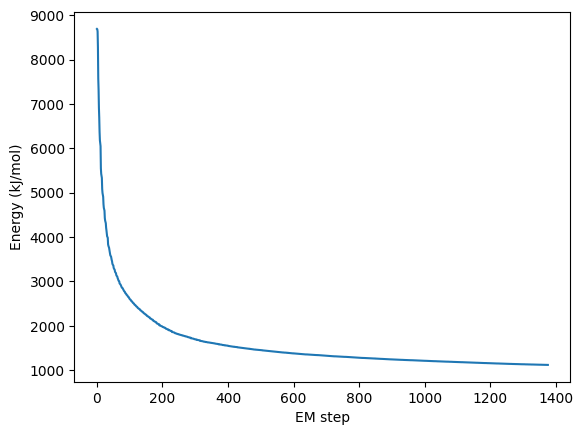

In [ ]:
# Potential PLOT

import matplotlib.pyplot as plt

x, y = [], []
with open("potential.xvg") as f:
    for line in f:
        if line.startswith(("#", "@")):
            continue
        cols = line.split()
        x.append(float(cols[0]))
        y.append(float(cols[1]))

plt.plot(x, y)
plt.xlabel("EM step")
plt.ylabel("Energy (kJ/mol)")
plt.show()


## **Step 6:** Equilibration

###NVT

In [ ]:
print("Creating nvt.mdp file for NVT equilibration...")

mdp_content = """
integrator  = md            ; Algorithm for molecular dynamics simulation
dt          = 0.002         ; Time step in ps, 2 fs
nsteps        = 50000         ; Total number of steps, 50000 * 0.002 ps = 100 ps total simulation time
nstlist       = 10            ; Update neighbor list every 10 steps
nstxout       = 5000          ; Save coordinates every 5000 steps (10 ps)
nstvout       = 5000          ; Save velocities every 5000 steps (10 ps)
nstfout       = 5000          ; Save forces every 5000 steps (10 ps)
nstlog        = 5000          ; Save log info every 5000 steps (10 ps)
nstenergy     = 100           ; Save energies every 100 steps (0.2 ps)
cutoff-scheme = Verlet        ; Use the Verlet cutoff scheme
coulombtype = PME           ; Particle Mesh Ewald for long-range electrostatics
rcoulomb      = 1.0           ; Cut-off for Coulomb interactions (nm)
vdwtype       = cutoff        ; Van der Waals interactions with a cutoff
rvdw          = 1.0           ; Cut-off for Van der Waals interactions (nm)
pbc           = xyz           ; 3D Periodic Boundary Conditions
tcoupl        = V-rescale     ; Temperature coupling using V-rescale thermostat
tc-grps       = Protein Non-Protein ; Groups to temperature couple independently
tau_t         = 0.1 0.1       ; Time constant for temperature coupling (ps)
ref_t         = 303.15 303.15 ; Reference temperature for each group (K)
gen_vel       = yes           ; Generate velocities according to Maxwell distribution
gen_temp      = 303.15        ; Temperature for Maxwell distribution (K)
gen_seed      = 1234          ; Seed for random velocity generation
"""

with open("nvt.mdp", "w") as f:
    f.write(mdp_content)

print("nvt.mdp created successfully.")

Creating nvt.mdp file for NVT equilibration...
nvt.mdp created successfully.


In [ ]:
# NVT (Constant Volume)
!/usr/local/gromacs/bin/gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr -maxwarn 4

      :-) GROMACS - gmx grompp, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff    

In [ ]:
!/usr/local/gromacs/bin/gmx mdrun -deffnm nvt -nb gpu -pme gpu -update gpu -bonded gpu -ntmpi 1 -ntomp 2 -pin on -v


      :-) GROMACS - gmx mdrun, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff     

In [ ]:
!printf "15\n" | /usr/local/gromacs/bin/gmx energy -f nvt.edr -o temperature.xvg


      :-) GROMACS - gmx energy, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff    

Data shape: (501, 2)
Header sample: ['# This file was created Fri Dec  5 14:17:47 2025', '# Created by:', '#      :-) GROMACS - gmx energy, 2021.4-dev-20211104-8a43d865d0-unknown (-:', '#', '# Executable:   /usr/local/gromacs/bin/gmx']


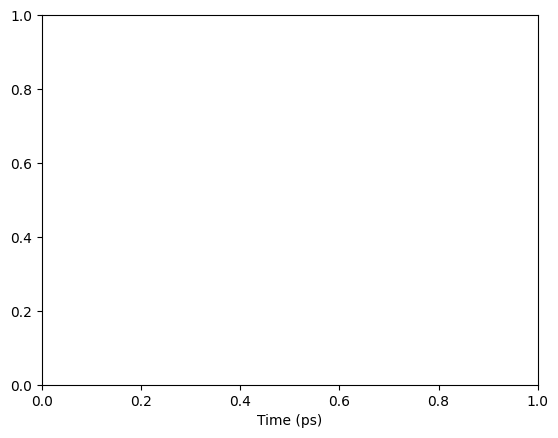

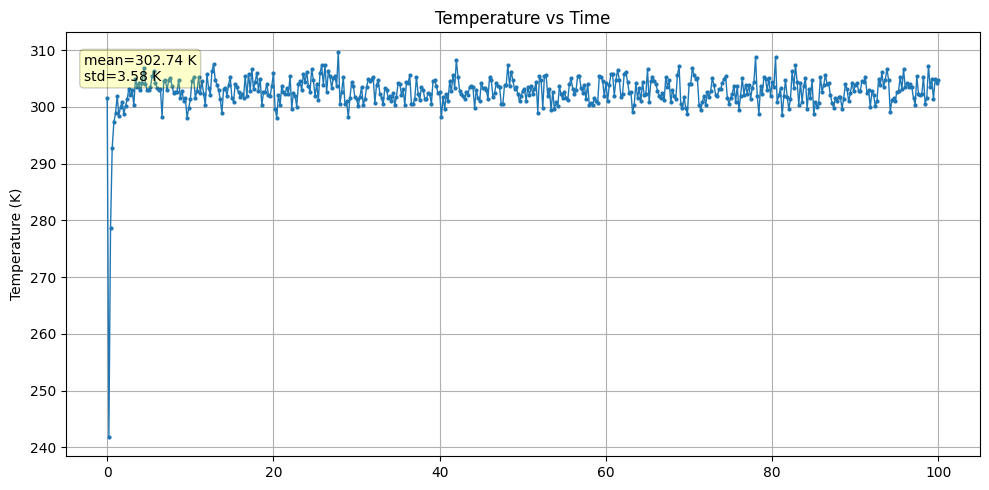

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fname = "temperature.xvg"

# Read numeric lines only
data = []
header_lines = []
with open(fname) as f:
    for line in f:
        line = line.strip()
        if line.startswith(('@', '#')):
            header_lines.append(line)
            continue
        try:
            cols = [float(x) for x in line.split()]
            data.append(cols)
        except ValueError:
            continue

data = np.array(data)
if data.size == 0:
    raise SystemExit("No numeric data found in the file.")

# Check the shape
print("Data shape:", data.shape)
print("Header sample:", header_lines[:5])

time = data[:,0]

# Look for the right temperature column
# Often column 1 is instantaneous temperature, column 2 is smoothed or reference
# You can check the header_lines for "@ s0 legend ..." to identify columns
T = data[:,1]  # Usually the actual system temperature

# Optional: convert time to ns if values are large
if time.max() > 1e4:  # likely in ps
    time = time / 1000
    plt.xlabel("Time (ns)")
else:
    plt.xlabel("Time (ps)")

# Plot
plt.figure(figsize=(10,5))
plt.plot(time, T, '-o', markersize=2, linewidth=1)
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Time")
plt.grid(True)

meanT = T.mean()
stdT = T.std()
plt.annotate(f"mean={meanT:.2f} K\nstd={stdT:.2f} K",
             xy=(0.02,0.95), xycoords='axes fraction', va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.2))

plt.tight_layout()
plt.show()


###NPT

In [ ]:
print("Creating npt.mdp file for NPT equilibration...")

mdp_content = """
integrator  = md            ; Algorithm for molecular dynamics simulation
dt          = 0.002         ; Time step in ps, 2 fs
nsteps        = 50000         ; Total number of steps, 50000 * 0.002 ps = 100 ps total simulation time
nstlist       = 10            ; Update neighbor list every 10 steps
nstxout       = 5000          ; Save coordinates every 5000 steps (10 ps)
nstvout       = 5000          ; Save velocities every 5000 steps (10 ps)
nstfout       = 5000          ; Save forces every 5000 steps (10 ps)
nstlog        = 5000          ; Save log info every 5000 steps (10 ps)
nstenergy     = 100           ; Save energies every 100 steps (0.2 ps)
cutoff-scheme = Verlet        ; Use the Verlet cutoff scheme
coulombtype = PME           ; Particle Mesh Ewald for long-range electrostatics
rcoulomb      = 1.0           ; Cut-off for Coulomb interactions (nm)
vdwtype       = cutoff        ; Van der Waals interactions with a cutoff
rvdw          = 1.0           ; Cut-off for Van der Waals interactions (nm)
pbc           = xyz           ; 3D Periodic Boundary Conditions
tcoupl        = V-rescale     ; Temperature coupling using V-rescale thermostat
tc-grps       = Protein Non-Protein ; Groups to temperature couple independently
tau_t         = 0.1 0.1       ; Time constant for temperature coupling (ps)
ref_t         = 303.15 303.15 ; Reference temperature for each group (K)
pcoupl        = Parrinello-Rahman ; Pressure coupling using Parrinello-Rahman barostat
pcoupltype    = isotropic     ; Isotropic pressure coupling
tau_p         = 2.0           ; Time constant for pressure coupling (ps)
ref_p         = 1.0           ; Reference pressure (bar)
compressibility = 4.5e-5      ; Isothermal compressibility (bar^-1)
gen_vel       = no            ; Do not generate velocities, continue from NVT
gen_seed      = 1234          ; Seed for random number generator
"""

with open("npt.mdp", "w") as f:
    f.write(mdp_content)

print("npt.mdp created successfully.")

Creating npt.mdp file for NPT equilibration...
npt.mdp created successfully.


In [ ]:
# NPT (Constant Pressure)

!/usr/local/gromacs/bin/gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr -maxwarn 4

      :-) GROMACS - gmx grompp, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff    

In [ ]:
!/usr/local/gromacs/bin/gmx mdrun -deffnm npt -nb gpu -pme gpu -update gpu -bonded gpu -ntmpi 1 -ntomp 2 -pin on -v

      :-) GROMACS - gmx mdrun, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff     

In [ ]:
!printf "16\n" | /usr/local/gromacs/bin/gmx energy -f npt.edr -o pressure.xvg


      :-) GROMACS - gmx energy, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff    

Mean Pressure = -6.11 bar
Std Dev = 171.87 bar


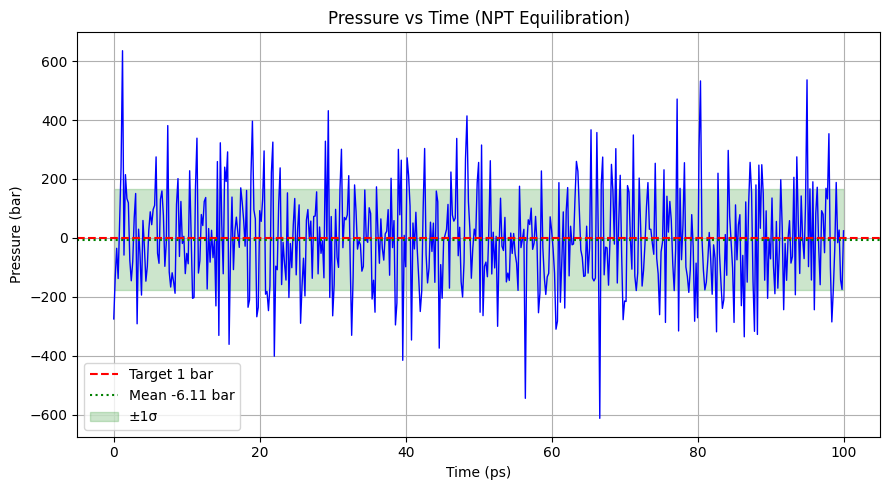

In [ ]:
# Pressure PLOT

import numpy as np
import matplotlib.pyplot as plt

# --- Read pressure.xvg ---
time, pres = [], []
with open("pressure.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):
            continue
        parts = line.split()
        if len(parts) >= 2:
            time.append(float(parts[0]))
            pres.append(float(parts[1]))

time = np.array(time)
pres = np.array(pres)

# --- Compute stats ---
meanP = pres.mean()
stdP = pres.std()

print(f"Mean Pressure = {meanP:.2f} bar")
print(f"Std Dev = {stdP:.2f} bar")

# --- Plot ---
plt.figure(figsize=(9,5))
plt.plot(time, pres, lw=1, color="blue")
plt.axhline(1.0, color="red", linestyle="--", label="Target 1 bar")  # default ref. pressure
plt.axhline(meanP, color="green", linestyle=":", label=f"Mean {meanP:.2f} bar")
plt.fill_between(time, meanP-stdP, meanP+stdP, alpha=0.2, color="green", label="±1σ")
plt.xlabel("Time (ps)")
plt.ylabel("Pressure (bar)")
plt.title("Pressure vs Time (NPT Equilibration)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 7:** MD (2ns=30min for 2mer/30aa)

In [ ]:
print("Creating md.mdp file for production MD...")

mdp_content = """
;==============================================================
;   Production Molecular Dynamics (NPT)
;   Stable for 10–200 ns (GROMACS 2023+)
;==============================================================

; Run control
integrator      = md
dt              = 0.002        ; 2 fs timestep
nsteps          = 1000000      ; 2 ns run (change as needed)

; Output
nstxout         = 0
nstvout         = 0
nstfout         = 0
nstenergy       = 1000
nstlog          = 1000
nstxout-compressed = 1000

; Neighbor searching
cutoff-scheme   = Verlet
ns_type         = grid
nstlist         = 20
rlist           = 1.2

; Electrostatics + VDW
coulombtype     = PME
rcoulomb        = 1.2
vdwtype         = cutoff
rvdw            = 1.2
DispCorr        = EnerPres

; Temperature coupling
tcoupl          = Nose-Hoover
tc-grps         = Protein Non-Protein
tau_t           = 1.0 1.0
ref_t           = 300 300

; Pressure coupling (NPT)
pcoupl          = Parrinello-Rahman
pcoupltype      = isotropic
tau_p           = 5.0
ref_p           = 1.0
compressibility = 4.5e-5

; Constraints
constraints             = h-bonds
constraint_algorithm    = lincs
lincs_iter              = 2
lincs_order             = 4

; Do NOT generate velocities in production
gen_vel         = no
"""

with open("md.mdp", "w") as f:
    f.write(mdp_content)

print("md.mdp created successfully.")


Creating md.mdp file for production MD...
md.mdp created successfully.


In [ ]:
!/usr/local/gromacs/bin/gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

      :-) GROMACS - gmx grompp, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff    

In [ ]:
!/usr/local/gromacs/bin/gmx mdrun -deffnm md -nb gpu -pme gpu -bonded gpu -ntmpi 1 -ntomp 2 -pin on -v

      :-) GROMACS - gmx mdrun, 2021.4-dev-20211104-8a43d865d0-unknown (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff     

## **Step 7:** Analyzing the simulation

In [ ]:
# 1️⃣ Remove PBC and center trajectory (center on System, output System)
!printf "0\n0\n" | /usr/local/gromacs/bin/gmx trjconv \
    -s md.tpr \
    -f md.xtc \
    -o md_noPBC.xtc \
    -pbc nojump \
    -ur compact \
    -center

# 2️⃣ Fit protein backbone for RMSD analysis
!printf "4\n1\n" | /usr/local/gromacs/bin/gmx trjconv \
    -s md.tpr \
    -f md_noPBC.xtc \
    -fit rot+trans \
    -o md_fitted.xtc

# 3️⃣ Optional: extract first frame as PDB reference
!printf "4\n1\n" | /usr/local/gromacs/bin/gmx trjconv \
    -s md.tpr \
    -f md_noPBC.xtc \
    -fit rot+trans \
    -b 0 -e 0 \
    -o md_ref.pdb

# 4️⃣ Optional: strip water (assume Protein is index 1)
!printf "1\n" | /usr/local/gromacs/bin/gmx trjconv \
    -s md.tpr \
    -f md_fitted.xtc \
    -o md_noWAT.xtc


In [ ]:
#Get RMSD

!printf "1\n1\n" | /usr/local/gromacs/bin/gmx trjconv -f npt.gro -s md.tpr -o protein_ref.gro

In [ ]:
!printf "1\n1\n" | /usr/local/gromacs/bin/gmx rms -s md.tpr -f md_fitted.xtc -o rmsd_xtal.xvg -tu ns

In [ ]:
# RMSD PLOT
import numpy as np
import matplotlib.pyplot as plt

# --- Read RMSD data from .xvg ---
time, rmsd = [], []
with open("rmsd_xtal.xvg") as f:
    for line in f:
        if line.startswith(('#', '@')):  # skip headers
            continue
        parts = line.split()
        if len(parts) >= 2:
            time.append(float(parts[0]))  # time in ns (because -tu ns)
            rmsd.append(float(parts[1]))  # RMSD in nm

time = np.array(time)
rmsd = np.array(rmsd)

# --- Compute basic stats ---
mean_rmsd = rmsd.mean()
max_rmsd = rmsd.max()
print(f"Mean RMSD = {mean_rmsd:.3f} nm")
print(f"Max RMSD  = {max_rmsd:.3f} nm")

# --- Plot ---
plt.figure(figsize=(9,5))
plt.plot(time, rmsd, lw=1.2, color="blue")
plt.axhline(mean_rmsd, color="red", linestyle="--", label=f"Mean = {mean_rmsd:.2f} nm")
plt.xlabel("Time (ns)")
plt.ylabel("RMSD (nm)")
plt.title("RMSD vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Get RMSF
!printf "1\n1\n" | /usr/local/gromacs/bin/gmx rmsf -s md.tpr -f md_fitted.xtc -o rmsf_ca.xvg -res

In [ ]:
# RMSF PLOT

import numpy as np
import matplotlib.pyplot as plt

# --- Read RMSF data ---
resid, rmsf = [], []
with open("rmsf_ca.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):  # skip metadata
            continue
        parts = line.split()
        if len(parts) >= 2:
            resid.append(int(float(parts[0])))   # residue index
            rmsf.append(float(parts[1]))         # RMSF in nm

resid = np.array(resid)
rmsf = np.array(rmsf)

# --- Compute stats ---
mean_rmsf = rmsf.mean()
max_rmsf = rmsf.max()
print(f"Mean RMSF = {mean_rmsf:.3f} nm")
print(f"Max RMSF  = {max_rmsf:.3f} nm at residue {resid[rmsf.argmax()]}")

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(resid, rmsf, lw=1.2, color="blue")
plt.axhline(mean_rmsf, color="red", linestyle="--", label=f"Mean = {mean_rmsf:.3f} nm")
plt.xlabel("Residue Index")
plt.ylabel("RMSF (nm)")
plt.title("Residue-wise RMSF (Cα atoms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Analyzing Compactness: Rg
#!/usr/local/gromacs/bin/gmx make_ndx -f md.tpr -o index.ndx
!printf "1\n1\n" | /usr/local/gromacs/bin/gmx gyrate -s md.tpr -f md_fitted.xtc -o gyrate.xvg

In [ ]:
# Rg PLOT
import numpy as np
import matplotlib.pyplot as plt

# --- Read gyration data ---
time, rg, rgx, rgy, rgz = [], [], [], [], []
with open("gyrate.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):  # skip headers
            continue
        parts = line.split()
        if len(parts) >= 2:
            time.append(float(parts[0]))
            rg.append(float(parts[1]))
            if len(parts) > 2:  # optional components
                rgx.append(float(parts[2]))
            if len(parts) > 3:
                rgy.append(float(parts[3]))
            if len(parts) > 4:
                rgz.append(float(parts[4]))

time = np.array(time)
rg = np.array(rg)

# --- Stats ---
mean_rg = rg.mean()
std_rg = rg.std()
print(f"Mean Rg = {mean_rg:.3f} nm")
print(f"Std Dev = {std_rg:.3f} nm")

# --- Plot Rg ---
plt.figure(figsize=(9,5))
plt.plot(time, rg, lw=1.2, color="blue", label="Rg total")
plt.axhline(mean_rg, color="red", linestyle="--", label=f"Mean = {mean_rg:.3f} nm")
plt.fill_between(time, mean_rg-std_rg, mean_rg+std_rg, color="red", alpha=0.2, label="±1σ")
plt.xlabel("Time (ns)")
plt.ylabel("Radius of Gyration (nm)")
plt.title("Radius of Gyration vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- (Optional) per-axis plots if data exist ---
if rgx and rgy and rgz:
    plt.figure(figsize=(9,5))
    plt.plot(time, rgx, label="RgX")
    plt.plot(time, rgy, label="RgY")
    plt.plot(time, rgz, label="RgZ")
    plt.xlabel("Time (ns)")
    plt.ylabel("Rg component (nm)")
    plt.title("Radius of Gyration Components")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Hydrogen Bond Analysis

!printf "1\n1\n" | /usr/local/gromacs/bin/gmx hbond -s md.tpr -f md_fitted.xtc -tu ns -num hbnum_mainchain.xvg

In [ ]:
!printf "1\n1\n" | /usr/local/gromacs/bin/gmx hbond -s md.tpr -f md_fitted.xtc -tu ns -num hbnum_sidechain.xvg

In [ ]:
# Hbond PLOTS
import numpy as np
import matplotlib.pyplot as plt

def read_xvg(filename):
    """Read GROMACS .xvg (time, value)."""
    time, values = [], []
    with open(filename) as f:
        for line in f:
            if line.startswith(('#', '@')):
                continue
            parts = line.split()
            if len(parts) >= 2:
                time.append(float(parts[0]))
                values.append(float(parts[1]))
    return np.array(time), np.array(values)

# --- Read files ---
t1, mainchain = read_xvg("hbnum_mainchain.xvg")
t2, sidechain = read_xvg("hbnum_sidechain.xvg")

# --- Sanity check: ensure time axes are similar ---
if not np.allclose(t1, t2):
    print("⚠️ Warning: time axes differ across files. Will plot separately.")

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(t1, mainchain, label="Mainchain H-bonds", lw=1.2)
plt.plot(t2, sidechain, label="Sidechain H-bonds", lw=1.2)

plt.xlabel("Time (ns)")
plt.ylabel("Number of H-bonds")
plt.title("Hydrogen Bonds vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()